save the data for figures for the Atlantic box;

In [2]:
import os,sys
import numpy as np
import xarray as xr
import zarr
# plot
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap

# plota
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
CB_colors = {
	'blue':	'#377eb8',
	'orange':  '#ff7f00',
	'green':   '#4daf4a',
	'pink':	'#f781bf',
	'brown':   '#a65628',
	'purple':  '#984ea3',
	'gray':	'#999999',
	'red': 	'#e41a1c',
	'yellow':  '#dede00'
}

# from dask.distributed import Client
import multiprocessing.popen_spawn_posix
from distributed import Client

c = Client()
c

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40399 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:41303 Dashboard: http://127.0.0.1:40399/status,Cluster Workers: 5 Cores: 10 Memory: 322.12 GB


In [3]:
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh_hgr = xr.open_dataset(diri+'mesh_hgr.nc').squeeze()
tmask = mesh_hgr.tmask[0].drop_vars('nav_lev').drop_vars('time_counter')
nav_lon =  mesh_hgr.nav_lon
nav_lat =  mesh_hgr.nav_lat

e1t = mesh_hgr.e1t.fillna(0)
e2t = mesh_hgr.e2t.fillna(0)

In [18]:
dir_sc = os.environ['SCRATCH']
dir_work = os.environ['WORK']

diro = dir_work + "/ETUDE3/ENS_VAR_BUDGET/PLOTS/"

dir_data = dir_work + "/ETUDE3/ENS_VAR_BUDGET/data4analyses/"
my_regions_masks = xr.open_zarr(dir_data+"my_regions_masks.zarr")

In [5]:
# constructing the weight for the Atlantic box
bt = (e1t * e2t).load()# area of each cell
# getting the weights to be applied to every grid cell
# masking the land cells
oceanArea = (bt*tmask).where(my_regions_masks.mask_atl)  #tmask : 1 on ocean, 0 on land
totalOceanArea = oceanArea.sum()
Weight = (oceanArea/totalOceanArea).compute().drop_vars('time_counter')

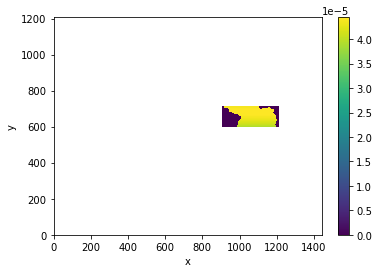

In [6]:
Weight.plot()

# Save for the SLA and the MANO

In [33]:
%%time

for COMP in ["SLA","MANO"]: # , for MANO: change to '_E_2use_1980_2018.zarr'
    if COMP=="SLA":
        varname = 'SSH_E'
    else:
        varname = COMP+'_E'

    for nexp in ["EAI", 'ES']:
        dir_base = dir_work + "/ETUDE3/ENS_VAR_BUDGET/data4analyses/"+nexp+"/"+COMP+"/"
        
        if COMP=="MANO":
            SSH = xr.open_zarr(dir_base+COMP+"_E_2use_1980_2018.zarr")[varname]*100 # in cm
        else:
            SSH = xr.open_zarr(dir_base+COMP+"_2use_1980_2018.zarr")[varname]*100 # in cm

        SSH = (SSH*Weight).sum(('x','y'))
        
        SSH.to_dataset(name="ts_box_atl").to_zarr(dir_base+"time_series_box_atl.zarr", mode='w')


CPU times: user 12.2 s, sys: 1.15 s, total: 13.4 s
Wall time: 17.4 s


In [35]:
%%time
central_year = 1999

for COMP in ["SLA", "MANO"]: 
    for nexp in ["EAI", 'ES']:
        
        dir_base = dir_work + "/ETUDE3/ENS_VAR_BUDGET/data4analyses/"+nexp+"/"+COMP+"/"

        SSH = xr.open_zarr(dir_base+"time_series_box_atl.zarr").ts_box_atl # in cm
        
        final_matrix = np.zeros((4))

        i = 19
        SSH_period = SSH.sel(time_counter=slice(str(central_year-i),str(central_year+i)))
        TimeMean_SSH = SSH_period.mean('time_counter').compute()
        EnsMean_SSH = SSH_period.mean('ens').compute()
        
        tot_var       = (((SSH_period - TimeMean_SSH)**2).mean("time_counter") ).mean("ens")
        forced_var    = ((EnsMean_SSH - EnsMean_SSH.mean("time_counter"))**2).mean("time_counter")
        intrinsic_var = (((SSH_period - EnsMean_SSH)**2).mean("ens")).mean('time_counter')
        res_var       = ((TimeMean_SSH - TimeMean_SSH.mean('ens'))**2).mean('ens')

        final_matrix[:] = [tot_var.values, forced_var.values, intrinsic_var.values, res_var.values]

        Variance_terms = xr.Dataset(
            data_vars = dict(variances=(["var_term"], final_matrix)),
            coords = dict(
                var_term = (["tot_var","forced_var","intrinsic_var","res_var"]))
                                    )
        Variance_terms.to_zarr(dir_base+"var_terms_box_atl.zarr", mode='w')

CPU times: user 812 ms, sys: 122 ms, total: 934 ms
Wall time: 2.68 s


# save the COMP in the atlantic box time series for (ens, time) and the variance terms for the DEPTHS RANGES

In [19]:
%%time

for COMP in ["STERIC", "THERMO", "HALO"]: # , for MANO: change to '_E_2use_1980_2018.zarr'
    varname = COMP+'_E'

    for nexp in ["EAI", 'ES']:
        dir_base = dir_sc + "/NEW_ENS_VAR_BUDGET/"+nexp+"/"+COMP+"/"

        for dep in ["50m", "100m", "300m", "700m", "2000m", "bottom"]: 
            print(dep)
            SSH = xr.open_zarr(dir_base+COMP+"_0_"+dep+"_2use_1980_2018.zarr")[varname]*100 # in cm
            
            SSH = (SSH*Weight).sum(('x','y'))
            
            SSH.to_dataset(name="ts_box_atl").to_zarr(dir_base+"time_series_box_atl_0_"+dep+".zarr", mode='w')


50m
100m
300m
700m
2000m
bottom
50m
100m
300m
700m
2000m
bottom
50m
100m
300m
700m
2000m
bottom
50m
100m
300m
700m
2000m
bottom
50m
100m
300m
700m
2000m
bottom
50m
100m
300m
700m
2000m
bottom
CPU times: user 1min 56s, sys: 11.6 s, total: 2min 8s
Wall time: 2min 47s


In [23]:
%%time
central_year = 1999

for COMP in ["STERIC", "THERMO", "HALO"]: 
    for nexp in ["EAI", 'ES']:
        
        dir_base = dir_sc + "/NEW_ENS_VAR_BUDGET/"+nexp+"/"+COMP+"/"

        for dep in ["50m", "100m", "300m", "700m", "2000m", "bottom"]: 
            print(dep)
            SSH = xr.open_zarr(dir_base+"time_series_box_atl_0_"+dep+".zarr").ts_box_atl # in cm
            
            # final_matrix = np.zeros((20,4))
            final_matrix = np.zeros((4))

            # for i in np.arange(20):
            i = 19
            SSH_period = SSH.sel(year=slice(str(central_year-i),str(central_year+i)))
            TimeMean_SSH = SSH_period.mean('year').compute()
            EnsMean_SSH = SSH_period.mean('ens').compute()
            
            tot_var       = (((SSH_period - TimeMean_SSH)**2).mean("year") ).mean("ens")
            forced_var    = ((EnsMean_SSH - EnsMean_SSH.mean("year"))**2).mean("year")
            intrinsic_var = (((SSH_period - EnsMean_SSH)**2).mean("ens")).mean('year')
            res_var       = ((TimeMean_SSH - TimeMean_SSH.mean('ens'))**2).mean('ens')
    
            final_matrix[:] = [tot_var.values, forced_var.values, intrinsic_var.values, res_var.values]
    
            # create dataset and save
            # Variance_terms = xr.Dataset(
            #     data_vars = dict(variances=(["time_length", "var_term"], final_matrix)),
            #     coords = dict(
            #         time_length = ("time_length", [str(1+ i*2) for i in np.arange(20)]),
            #         var_term = ("var_term", ["tot_var","forced_var","intrinsic_var","res_var"]))
            
            Variance_terms = xr.Dataset(
                data_vars = dict(variances=(["var_term"], final_matrix)),
                coords = dict(
                    var_term = (["tot_var","forced_var","intrinsic_var","res_var"]))
                                        )
            Variance_terms.to_zarr(dir_base+"var_terms_box_atl_0_"+dep+".zarr", mode='w')

50m
100m
300m
700m
2000m
bottom
50m
100m
300m
700m
2000m
bottom
50m
100m
300m
700m
2000m
bottom
50m
100m
300m
700m
2000m
bottom
50m
100m
300m
700m
2000m
bottom
50m
100m
300m
700m
2000m
bottom
CPU times: user 8 s, sys: 1.01 s, total: 9.01 s
Wall time: 25.7 s
